In [179]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Sinogram

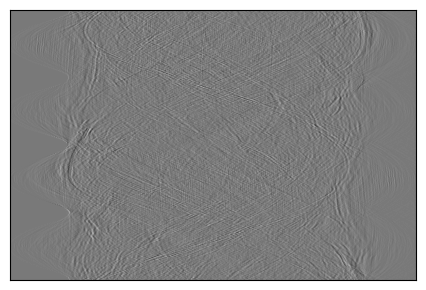

In [180]:
sinogram = np.load(os.path.join("../tutorials/data", "sinogram_simulation.npy")) 

plt.figure(figsize=(6,3))
plt.imshow(sinogram[:,920:1690], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

### PSF Stack

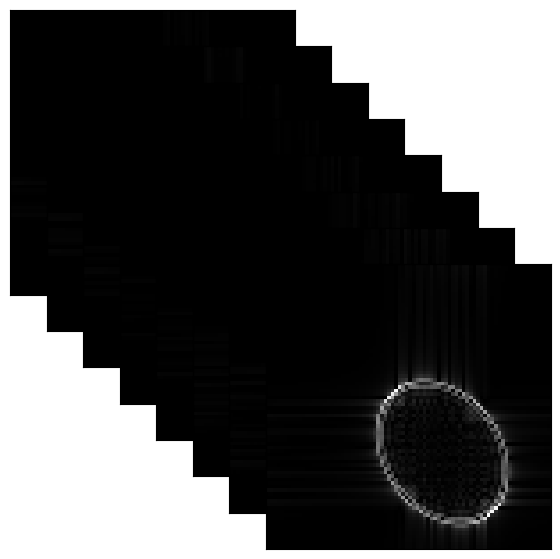

In [181]:
psfs = np.load('../data/psfs.npy')

fig = plt.figure(figsize=(7,7), facecolor='white')
gs = gridspec.GridSpec(15, 15)
for i in range(8):
    plt.subplot(gs[i:i+8,i:i+8])
    plt.imshow(psfs[7-i,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.savefig('../figures/psfs_stack.jpg', bbox_inches='tight')

### Full Image Stack

In [182]:
obss = np.load(os.path.join('../data', "obs_full_imgs.npy"))

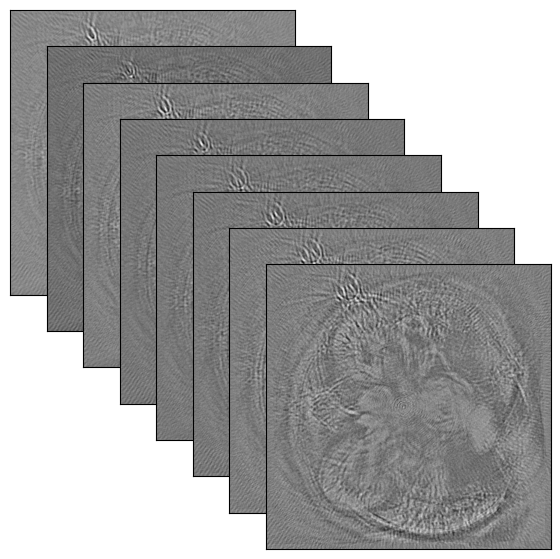

In [183]:
fig = plt.figure(figsize=(7,7), facecolor='white')
step = 40
gs = gridspec.GridSpec(15, 15)
for i in range(8):
    plt.subplot(gs[i:i+8,i:i+8])
    plt.imshow(obss[i,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.savefig('../figures/obs_full_stack.jpg', bbox_inches='tight')

### Clean Full Image

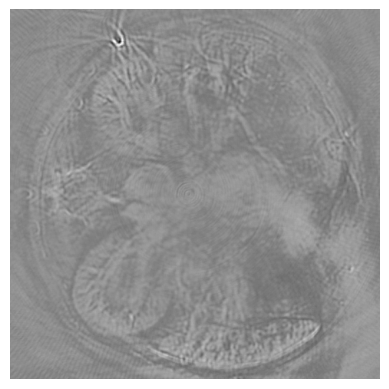

In [184]:
IP_img = np.load(os.path.join('../data', "IP_img.npy"))

plt.imshow(IP_img, cmap='gray')
plt.axis('off')
plt.savefig('../figures/IP_img.jpg', bbox_inches='tight')

### Small Patch Image Stack

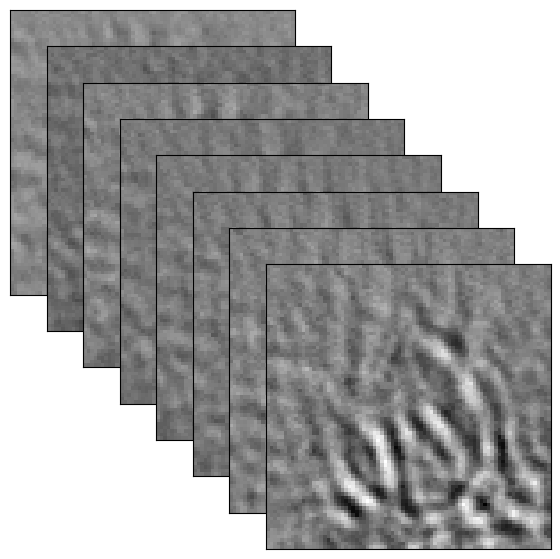

In [185]:
i, j = 0, 3
fig = plt.figure(figsize=(7,7), facecolor='white')
step = 40
gs = gridspec.GridSpec(15, 15)
for k in range(8):
    plt.subplot(gs[k:k+8,k:k+8])
    plt.imshow(obss[k,40*i:40*i+80, 40*j:40*j+80], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.savefig('../figures/obs_stack.jpg', bbox_inches='tight')

### Clean Small Patch

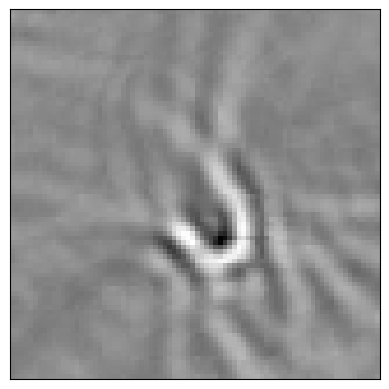

In [186]:
plt.imshow(IP_img[40*i:40*i+80, 40*j:40*j+80], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/IP_patch.jpg', bbox_inches='tight')

### Wavefront